In [ ]:
!unzip -n data/A.zip -d data/     # -n 不覆盖已存在的文件
!unzip -n data/train.zip -d data/

In [2]:
import numpy as np
import cv2
import os
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import time
from datetime import datetime

import torch
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data.dataset import Dataset

from sklearn.model_selection import StratifiedKFold

In [3]:
train_df = pd.read_csv("data/train.txt", sep="\t", header=None)
train_df[0] = 'data/train/' + train_df[0]
train_df

,0,1
0,data/train/5333375d0d28b52c3ea43d272c9b612a.jpg,无风险
1,data/train/fdb7644e238846f6e1a05c46503af1aa.jpg,无风险
2,data/train/7a007c8572d4a3c59ae1c9242affe446.jpg,无风险
3,data/train/c35e2ef70a577ee9f4dae73d31d3141d.jpg,无风险
4,data/train/4d14b5cb31d414ce61c586612605b230.jpg,无风险
...,...,...
3361,data/train/a11c14bf64c785f98ec163826ac1e777.jpg,高风险
3362,data/train/d101b130651c25fbe9de84e91d67ac8e.jpg,高风险
3363,data/train/946bb2f80a79f6eb6b1229cb3fefe01c.jpg,高风险
3364,data/train/1f6598231fcb84df895f13eed9e28004.jpg,高风险


In [4]:
def is_valid_image(image_path):
    if not os.path.exists(image_path):
        return False
    image = cv2.imread(image_path)
    return image is not None

train_df = train_df[train_df[0].apply(is_valid_image)]

Corrupt JPEG data: 360156 extraneous bytes before marker 0xe2


In [5]:
train_df

,0,1
0,data/train/5333375d0d28b52c3ea43d272c9b612a.jpg,无风险
1,data/train/fdb7644e238846f6e1a05c46503af1aa.jpg,无风险
2,data/train/7a007c8572d4a3c59ae1c9242affe446.jpg,无风险
3,data/train/c35e2ef70a577ee9f4dae73d31d3141d.jpg,无风险
4,data/train/4d14b5cb31d414ce61c586612605b230.jpg,无风险
...,...,...
3361,data/train/a11c14bf64c785f98ec163826ac1e777.jpg,高风险
3362,data/train/d101b130651c25fbe9de84e91d67ac8e.jpg,高风险
3363,data/train/946bb2f80a79f6eb6b1229cb3fefe01c.jpg,高风险
3364,data/train/1f6598231fcb84df895f13eed9e28004.jpg,高风险


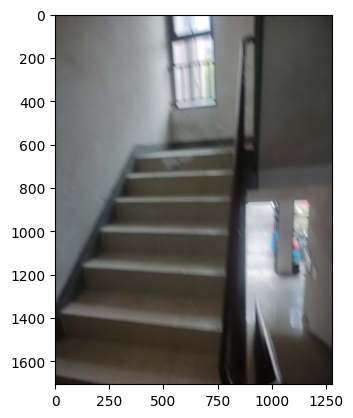

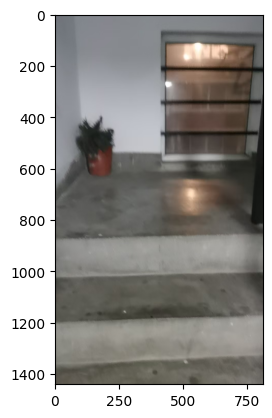

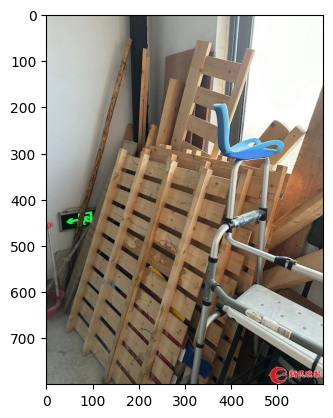

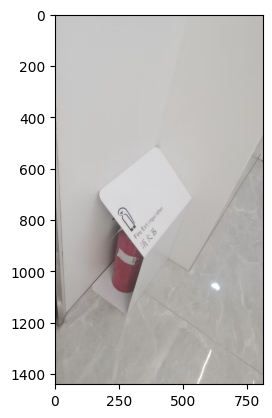

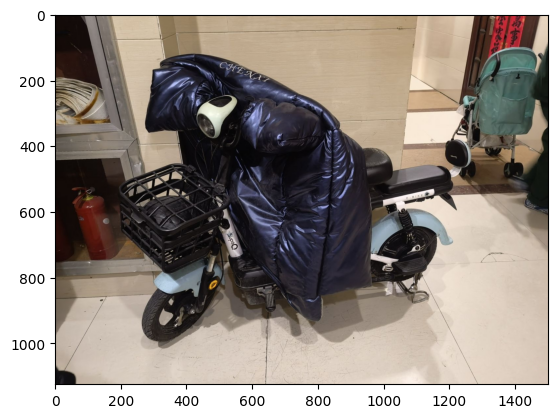

In [6]:
for lbl in train_df[1].value_counts().index:
    img = cv2.imread(train_df[train_df[1] == lbl][0].sample(1).values[0])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure()
    plt.imshow(img)

In [7]:
mapping_dict = {
    '高风险': 0,
    '中风险': 1,
    '低风险': 2,
    '无风险': 3,
    '非楼道': 4
}

train_df[1] = train_df[1].map(mapping_dict)

/tmp/ipykernel_9052/240159218.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[1] = train_df[1].map(mapping_dict)


In [8]:
class GalaxyDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        
        if transform is not None:
            self.transform = transform
        else:
            self.transform = None
    
    def __getitem__(self, index):
        start_time = time.time()
        img = Image.open(self.images[index]).convert('RGB')
        
        if self.transform is not None:
            img = self.transform(img)
        
        return img,torch.from_numpy(np.array(self.labels[index]))
    
    def __len__(self):
        return len(self.labels)

In [9]:
def get_model1():
    model = models.resnet18(True)
    model.fc = nn.Linear(512, 5)
    return model

def get_model3():
    models.efficientnet_b0(True)
    model.fc = nn.Linear(512, 5)
    return model

In [10]:
def validate(val_loader, model, criterion):
    # switch to evaluate mode
    model.eval()

    total_acc = 0
    with torch.no_grad():
        end = time.time()
        for i, (input, target) in enumerate(val_loader):
            input = input.cuda()
            target = target.cuda()

            # compute output
            output = model(input)
            loss = criterion(output, target)

            # measure accuracy and record loss
            total_acc += (output.argmax(1).long() == target.long()).sum().item()
    return total_acc / len(val_loader.dataset)

def train(train_loader, model, criterion, optimizer, epoch):

    # switch to train mode
    model.train()

    end = time.time()
    for i, (input, target) in enumerate(train_loader):
        input = input.cuda(non_blocking=True)
        target = target.cuda(non_blocking=True)

        # compute output
        output = model(input)
        loss = criterion(output, target)
        acc1 = (output.argmax(1).long() == target.long()).sum().item()

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if i % 100 == 0:
            print(datetime.now(), loss.item(), acc1 / input.size(0))

In [11]:
skf = StratifiedKFold(n_splits=5, random_state=233, shuffle=True)
for _, (train_idx, val_idx) in enumerate(skf.split(train_df[0].values, train_df[1].values)):
    break

In [12]:
train_loader = torch.utils.data.DataLoader(
    GalaxyDataset(train_df[0].iloc[train_idx].values, train_df[1].iloc[train_idx].values,
            transforms.Compose([
                        transforms.Resize((256, 256)),
                        transforms.RandomHorizontalFlip(),
                        transforms.RandomVerticalFlip(),
                        transforms.ToTensor(),
                        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    ), batch_size=20, shuffle=True, num_workers=20, pin_memory=True
)

val_loader = torch.utils.data.DataLoader(
    GalaxyDataset(train_df[0].iloc[val_idx].values, train_df[1].iloc[val_idx].values,
            transforms.Compose([
                        transforms.Resize((256, 256)),
                        transforms.ToTensor(),
                        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    ), batch_size=20, shuffle=False, num_workers=10, pin_memory=True
)

In [13]:
model = get_model1().cuda()
criterion = nn.CrossEntropyLoss().cuda()
optimizer = torch.optim.Adam(model.parameters(), 0.005)
best_acc = 0.0
for epoch in range(5):
    print('Epoch: ', epoch)

    train(train_loader, model, criterion, optimizer, epoch)
    val_acc = validate(val_loader, model, criterion)
    print("Val acc", val_acc)

/usr/local/lib/python3.11/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 52.6MB/s]


AssertionError: Torch not compiled with CUDA enabled

In [ ]:
model = get_model3().cuda()
criterion = nn.CrossEntropyLoss().cuda()
optimizer = torch.optim.Adam(model.parameters(), 0.003)
best_acc = 0.0
for epoch in range(5):
    print('Epoch: ', epoch)

    train(train_loader, model, criterion, optimizer, epoch)
    val_acc = validate(val_loader, model, criterion)
    print("Val acc", val_acc)

In [ ]:
def predict(test_loader, model):
    # switch to evaluate mode
    model.eval()
    pred = [] 
    with torch.no_grad():
        end = time.time()
        for i, (input, target) in enumerate(test_loader):
            input = input.cuda()
            target = target.cuda()

            # compute output
            output = model(input)
            loss = criterion(output, target)

            pred += list(output.argmax(1).long().cpu().numpy())
    return pred

In [ ]:
test_df = pd.read_csv("data/A.txt", sep="\t", header=None)
test_df["path"] = 'data/A/' + test_df[0]
test_df["label"] = 1

test_loader = torch.utils.data.DataLoader(
    GalaxyDataset(test_df["path"].values, test_df["label"].values,
            transforms.Compose([
                        transforms.Resize((256, 256)),
                        transforms.ToTensor(),
                        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    ), batch_size=20, shuffle=False, num_workers=10, pin_memory=True
)
pred = predict(test_loader, model)
pred = np.stack(pred)

In [ ]:
inverse_mapping_dict = {v: k for k, v in mapping_dict.items()}
inverse_transform = np.vectorize(inverse_mapping_dict.get)
test_df["label"] = inverse_transform(pred)

In [ ]:
test_df[[0, "label"]].to_csv("submit.txt", index=None, sep="\t", header=None)